 Generating synthetic training data...
Data saved to finverse_training_data.csv

 Reading data from finverse_training_data.csv...
FINVERSE AI - DATASET ANALYSIS

 Dataset Overview:
   • Total Records: 8,000
   • Features: 7
   • Target Variables: 3 (Debt, Equity, Mutual Fund allocations)

 Data Types:
age                          int64
annual_income                int64
monthly_savings              int64
emergency_fund               int64
risk_appetite               object
investment_goal             object
existing_investment_pct    float64
debt_allocation            float64
equity_allocation          float64
mutual_fund_allocation     float64
dtype: object

Numerical Features Summary:
               age  annual_income  monthly_savings  emergency_fund  \
count  8000.000000   8.000000e+03      8000.000000    8.000000e+03   
mean     31.595500   8.981094e+05     16499.102250    6.866566e+04   
std       7.637845   5.839390e+05     12097.340623    7.366796e+04   
min      18.000000   3.0

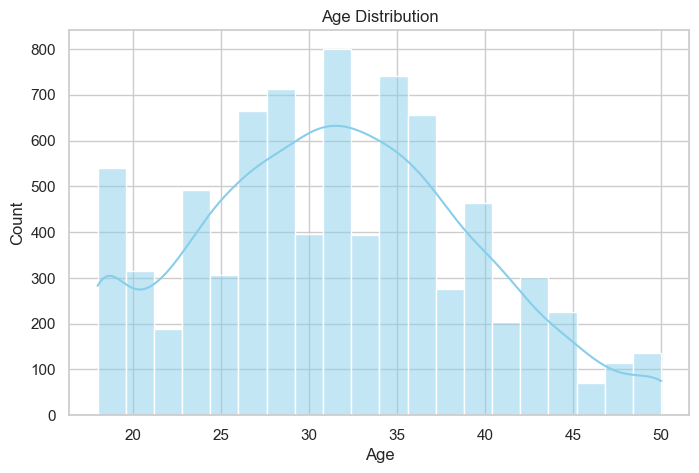

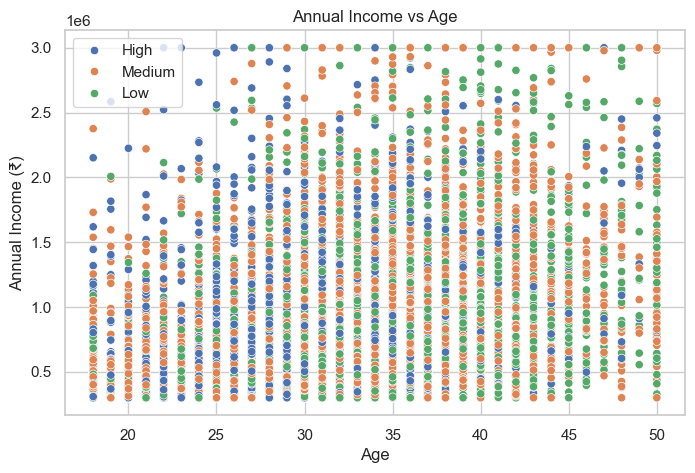

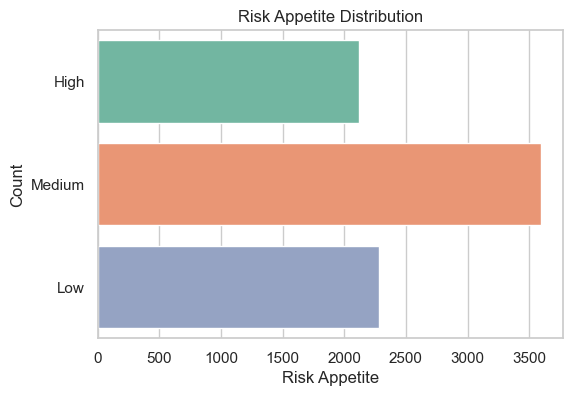

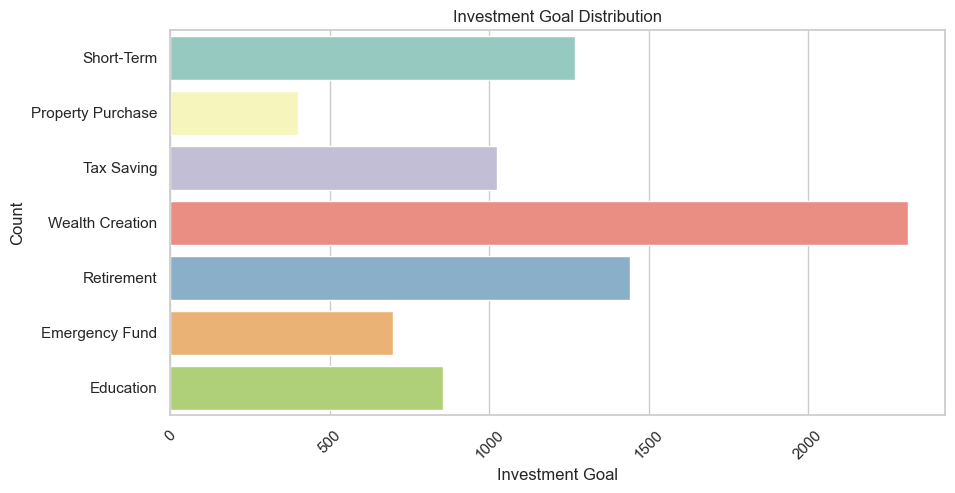

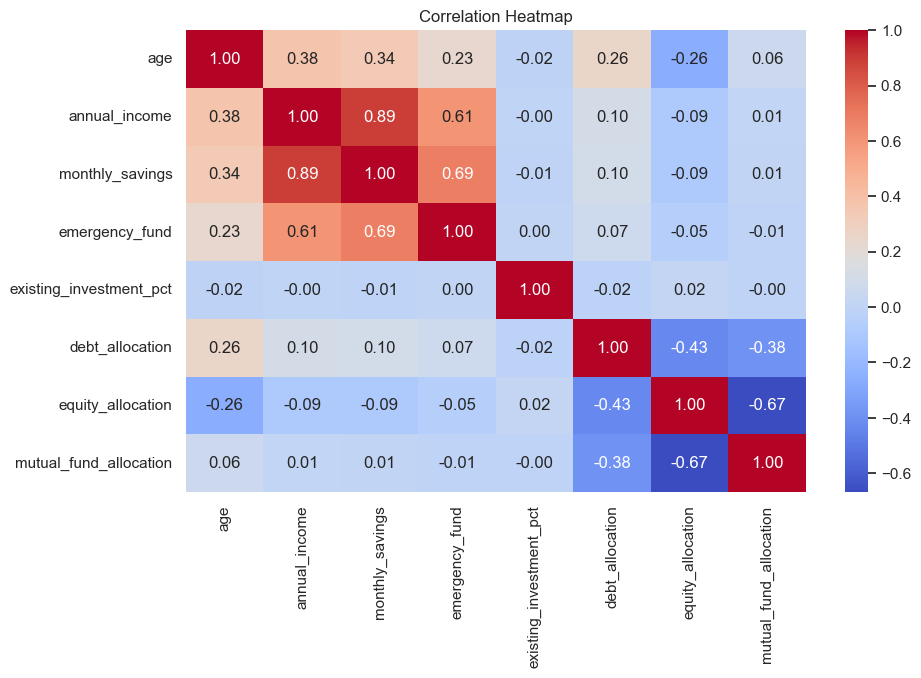

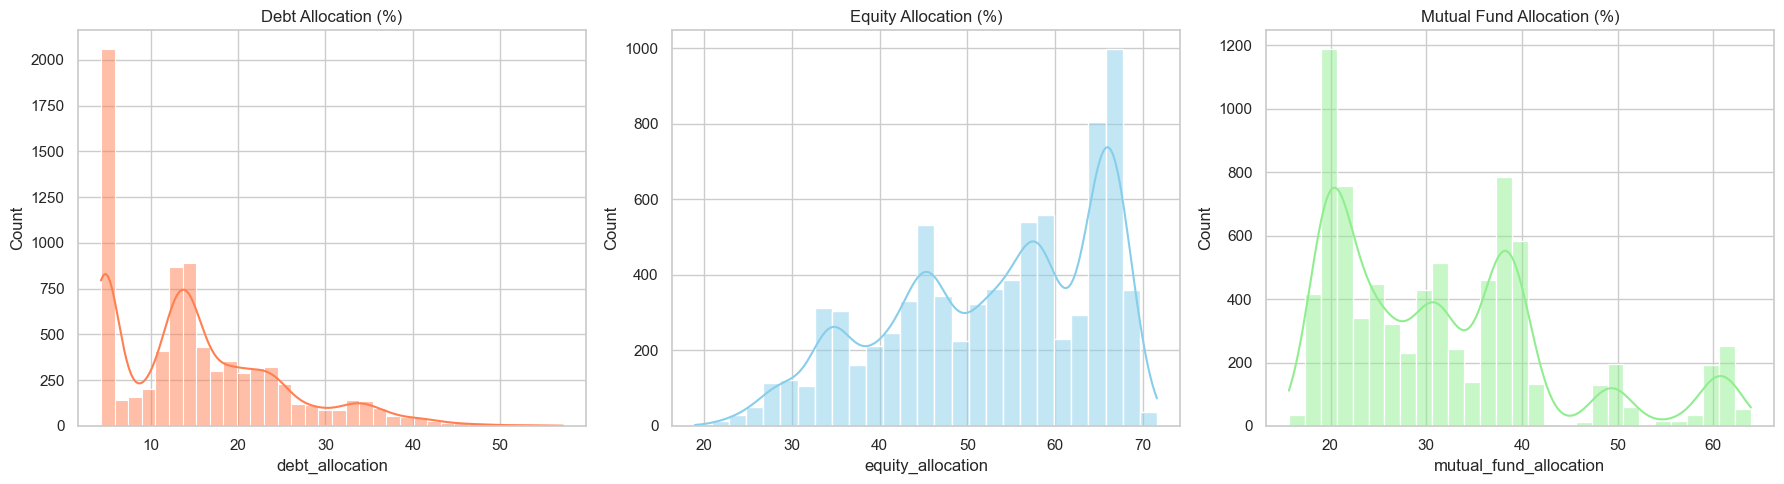

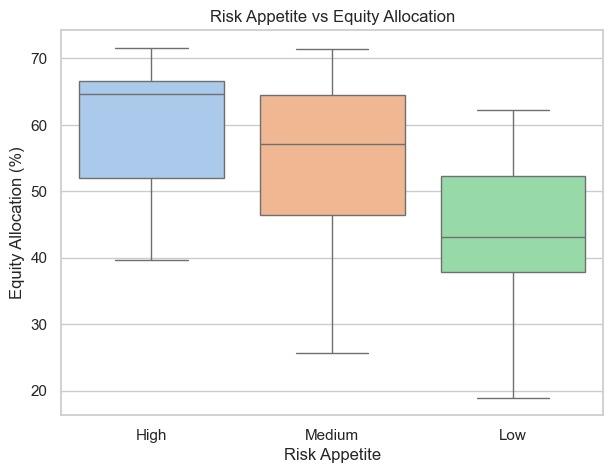

 Actual labels not available inside pipeline.

✅ FinVerse AI Investment Advisor training completed successfully!
Dataset: 8,000 records
🏆 Best Model: RandomForest
 Model saved: finverse_best_model_randomforest.pkl


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')


class FinVerseDataGenerator:
    def __init__(self):
        pass
    
    def generate_synthetic_data(self, n_samples=10000):
        """Generate realistic synthetic training data with age constraint 18-50"""
        np.random.seed(42)
        
        # Generate base features with age constraint 18-50
        age = np.random.normal(32, 8, n_samples).clip(18, 50)
        
        # Annual income based on age (younger = lower income generally)
        base_income = 400000 + (age - 18) * 25000  # Base income increases with age
        income_variation = np.random.lognormal(0, 0.6, n_samples)
        annual_income = (base_income * income_variation).clip(300000, 3000000)  # 3L to 30L
        
        # Monthly savings (10-40% of monthly income)
        savings_rate = np.random.beta(2, 3, n_samples) * 0.3 + 0.1  # 10-40%
        monthly_savings = (annual_income * savings_rate) / 12
        
        # Emergency fund (2-15 months of expenses)
        emergency_months = np.random.gamma(2, 2, n_samples).clip(2, 15)
        emergency_fund = monthly_savings * emergency_months
        
        # Risk appetite distribution (age-influenced)
        risk_probs = np.zeros((n_samples, 3))  # Low, Medium, High
        for i in range(n_samples):
            if age[i] < 30:
                risk_probs[i] = [0.2, 0.4, 0.4]  # Young people more risk-taking
            elif age[i] < 40:
                risk_probs[i] = [0.3, 0.5, 0.2]  # Middle-aged balanced
            else:
                risk_probs[i] = [0.5, 0.4, 0.1]  # Older people more conservative
        
        risk_appetite = []
        for i in range(n_samples):
            risk_appetite.append(np.random.choice(['Low', 'Medium', 'High'], p=risk_probs[i]))
        
        # Investment goals (age-influenced)
        goal_probs = np.zeros((n_samples, 7))
        goal_names = ['Wealth Creation', 'Retirement', 'Short-Term', 'Education', 
                     'Emergency Fund', 'Tax Saving', 'Property Purchase']
        
        for i in range(n_samples):
            if age[i] < 30:
                goal_probs[i] = [0.35, 0.1, 0.2, 0.15, 0.05, 0.1, 0.05]
            elif age[i] < 40:
                goal_probs[i] = [0.25, 0.2, 0.15, 0.1, 0.1, 0.15, 0.05]
            else:
                goal_probs[i] = [0.2, 0.35, 0.1, 0.05, 0.15, 0.1, 0.05]
        
        investment_goals = []
        for i in range(n_samples):
            investment_goals.append(np.random.choice(goal_names, p=goal_probs[i]))
        
        # Existing investment percentage (0-40%)
        existing_investment = np.random.beta(2, 5, n_samples) * 0.4
        
        # Create DataFrame
        data = pd.DataFrame({
            'age': age.astype(int),
            'annual_income': annual_income.astype(int),
            'monthly_savings': monthly_savings.astype(int),
            'emergency_fund': emergency_fund.astype(int),
            'risk_appetite': risk_appetite,
            'investment_goal': investment_goals,
            'existing_investment_pct': existing_investment.round(3)
        })
        
        # Generate target allocations
        allocations = self._generate_realistic_allocations(data)
        
        # Combine features and targets
        final_data = pd.concat([data, allocations], axis=1)
        
        return final_data
    
    def _generate_realistic_allocations(self, data):
        """Generate realistic allocation percentages"""
        n_samples = len(data)
        
        debt_allocation = np.zeros(n_samples)
        equity_allocation = np.zeros(n_samples)
        mutual_fund_allocation = np.zeros(n_samples)
        
        for i in range(n_samples):
            age = data.iloc[i]['age']
            risk = data.iloc[i]['risk_appetite']
            goal = data.iloc[i]['investment_goal']
            income = data.iloc[i]['annual_income']
            
            # Age-based allocation (100 - age rule modified for younger demographic)
            base_equity = max(30, min(70, 100 - age))
            
            # Risk appetite adjustment
            if risk == 'Low':
                equity_pct = base_equity * 0.7
                debt_pct = min(60, 70 - equity_pct)
            elif risk == 'Medium':
                equity_pct = base_equity * 0.9
                debt_pct = min(50, 60 - equity_pct)
            else:  # High risk
                equity_pct = min(75, base_equity * 1.3)
                debt_pct = max(15, 40 - equity_pct)
            
            # Goal-based adjustments
            if goal == 'Short-Term':
                debt_pct = min(70, debt_pct * 1.6)
                equity_pct = max(15, equity_pct * 0.6)
            elif goal == 'Retirement':
                if age < 35:
                    equity_pct = min(70, equity_pct * 1.1)
                else:
                    debt_pct = min(55, debt_pct * 1.2)
            elif goal == 'Education':
                debt_pct = min(55, debt_pct * 1.3)
                equity_pct = max(20, equity_pct * 0.8)
            elif goal == 'Wealth Creation':
                equity_pct = min(75, equity_pct * 1.2)
                debt_pct = max(15, debt_pct * 0.8)
            elif goal == 'Tax Saving':
                mutual_fund_pct = 40  # ELSS funds
                remaining = 60
                debt_pct = debt_pct * (remaining / (debt_pct + equity_pct))
                equity_pct = equity_pct * (remaining / (debt_pct + equity_pct))
            
            # Calculate mutual fund allocation
            if goal != 'Tax Saving':
                mutual_fund_pct = 100 - debt_pct - equity_pct
            
            # Ensure minimum diversification
            if mutual_fund_pct < 20:
                mutual_fund_pct = 20
                remaining = 80
                total_de = debt_pct + equity_pct
                if total_de > 0:
                    debt_pct = debt_pct * (remaining / total_de)
                    equity_pct = equity_pct * (remaining / total_de)
            
            # Add realistic noise
            noise = np.random.normal(0, 1.5, 3)
            debt_pct = max(5, debt_pct + noise[0])
            equity_pct = max(10, equity_pct + noise[1])
            mutual_fund_pct = max(15, mutual_fund_pct + noise[2])
            
            # Normalize to ensure sum = 100
            total = debt_pct + equity_pct + mutual_fund_pct
            debt_pct = (debt_pct / total) * 100
            equity_pct = (equity_pct / total) * 100
            mutual_fund_pct = (mutual_fund_pct / total) * 100
            
            # Store allocations
            debt_allocation[i] = round(debt_pct, 2)
            equity_allocation[i] = round(equity_pct, 2)
            mutual_fund_allocation[i] = round(mutual_fund_pct, 2)
        
        return pd.DataFrame({
            'debt_allocation': debt_allocation,
            'equity_allocation': equity_allocation,
            'mutual_fund_allocation': mutual_fund_allocation
        })
    
    def save_to_csv(self, data, filename='finverse_training_data.csv'):
        """Save data to CSV file"""
        data.to_csv(filename, index=False)
        print(f"Data saved to {filename}")
        return filename

class FinVerseAnalyzer:
    def __init__(self):
        pass
    
    def describe_data(self, data):
        """Comprehensive data analysis and description"""
        print("=" * 60)
        print("FINVERSE AI - DATASET ANALYSIS")
        print("=" * 60)
        
        print(f"\n Dataset Overview:")
        print(f"   • Total Records: {len(data):,}")
        print(f"   • Features: {len(data.columns) - 3}")
        print(f"   • Target Variables: 3 (Debt, Equity, Mutual Fund allocations)")
        
        print(f"\n Data Types:")
        print(data.dtypes)
        
        print(f"\nNumerical Features Summary:")
        numerical_cols = ['age', 'annual_income', 'monthly_savings', 'emergency_fund', 'existing_investment_pct']
        print(data[numerical_cols].describe())
        
        print(f"\n Target Variables Summary:")
        target_cols = ['debt_allocation', 'equity_allocation', 'mutual_fund_allocation']
        print(data[target_cols].describe())
        
        print(f"\n Categorical Features Distribution:")
        categorical_cols = ['risk_appetite', 'investment_goal']
        for col in categorical_cols:
            print(f"\n{col.upper()}:")
            counts = data[col].value_counts()
            for idx, count in counts.items():
                percentage = (count / len(data)) * 100
                print(f"   • {idx}: {count:,} ({percentage:.1f}%)")
        
        print(f"\n💡 Key Insights:")
        print(f"   • Average Age: {data['age'].mean():.1f} years")
        print(f"   • Median Income: ₹{data['annual_income'].median():,.0f}")
        print(f"   • Average Monthly Savings: ₹{data['monthly_savings'].mean():,.0f}")
        print(f"   • Average Emergency Fund: ₹{data['emergency_fund'].mean():,.0f}")
        
        # Age distribution insights
        young = (data['age'] < 30).sum()
        middle = ((data['age'] >= 30) & (data['age'] < 40)).sum()
        mature = (data['age'] >= 40).sum()
        
        print(f"\n Age Distribution:")
        print(f"   • Young (18-29): {young:,} ({young/len(data)*100:.1f}%)")
        print(f"   • Middle (30-39): {middle:,} ({middle/len(data)*100:.1f}%)")
        print(f"   • Mature (40-50): {mature:,} ({mature/len(data)*100:.1f}%)")
        
        # Allocation insights
        print(f"\n Average Allocations:")
        print(f"   • Debt Instruments: {data['debt_allocation'].mean():.1f}%")
        print(f"   • Equity: {data['equity_allocation'].mean():.1f}%")
        print(f"   • Mutual Funds: {data['mutual_fund_allocation'].mean():.1f}%")
        
        # Risk vs Allocation analysis
        print(f"\n Risk Appetite vs Average Equity Allocation:")
        risk_equity = data.groupby('risk_appetite')['equity_allocation'].mean()
        for risk, avg_equity in risk_equity.items():
            print(f"   • {risk} Risk: {avg_equity:.1f}% equity")
        
        return data

class FinVerseModelComparison:
    def __init__(self):
        self.models = {}
        self.results = {}
        
    def prepare_features(self, data):
        """Prepare features for training"""
        # Feature columns
        feature_cols = ['age', 'annual_income', 'monthly_savings', 'emergency_fund', 
                       'risk_appetite', 'investment_goal', 'existing_investment_pct']
        target_cols = ['debt_allocation', 'equity_allocation', 'mutual_fund_allocation']
        
        X = data[feature_cols]
        y = data[target_cols]
        
        # Numerical and categorical features
        numerical_features = ['age', 'annual_income', 'monthly_savings', 
                            'emergency_fund', 'existing_investment_pct']
        categorical_features = ['risk_appetite', 'investment_goal']
        
        # Create preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
            ]
        )
        
        return X, y, preprocessor
    
    def train_random_forest(self, X_train, y_train, preprocessor):
        """Train Random Forest model"""
        rf_model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(
                n_estimators=200,
                max_depth=20,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1
            ))
        ])
        
        rf_model.fit(X_train, y_train)
        return rf_model
    
    def train_xgboost(self, X_train, y_train, preprocessor):
        """Train XGBoost model"""
        xgb_model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', xgb.XGBRegressor(
                n_estimators=200,
                max_depth=8,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1
            ))
        ])
        
        xgb_model.fit(X_train, y_train)
        return xgb_model
    
    def evaluate_model(self, model, X_test, y_test, model_name):
        """Evaluate model performance"""
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        r2_scores = []
        mse_scores = []
        mae_scores = []
        
        target_names = ['Debt', 'Equity', 'Mutual Fund']
        
        print(f"\n {model_name} Performance:")
        print("-" * 40)
        
        for i, target in enumerate(target_names):
            r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
            mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
            mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
            
            r2_scores.append(r2)
            mse_scores.append(mse)
            mae_scores.append(mae)
            
            print(f"{target} Allocation:")
            print(f"   • R² Score: {r2:.4f}")
            print(f"   • MSE: {mse:.4f}")
            print(f"   • MAE: {mae:.4f}")
        
        # Overall metrics
        overall_r2 = np.mean(r2_scores)
        overall_mse = np.mean(mse_scores)
        overall_mae = np.mean(mae_scores)
        
        print(f"\nOverall Performance:")
        print(f"   • Average R² Score: {overall_r2:.4f}")
        print(f"   • Average MSE: {overall_mse:.4f}")
        print(f"   • Average MAE: {overall_mae:.4f}")
        
        return {
            'model': model,
            'r2_scores': r2_scores,
            'mse_scores': mse_scores,
            'mae_scores': mae_scores,
            'overall_r2': overall_r2,
            'overall_mse': overall_mse,
            'overall_mae': overall_mae,
            'predictions': y_pred
        }
    
    def compare_models(self, data):
        """Compare Random Forest and XGBoost models"""
        print("\n TRAINING AND COMPARING MODELS")
        print("=" * 50)
        
        # Prepare data
        X, y, preprocessor = self.prepare_features(data)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        print(f"Training set size: {len(X_train):,}")
        print(f"Test set size: {len(X_test):,}")
        
        # Train Random Forest
        print("\n🌳 Training Random Forest...")
        rf_model = self.train_random_forest(X_train, y_train, preprocessor)
        rf_results = self.evaluate_model(rf_model, X_test, y_test, "Random Forest")
        
        # Train XGBoost
        print("\n🚀 Training XGBoost...")
        xgb_model = self.train_xgboost(X_train, y_train, preprocessor)
        xgb_results = self.evaluate_model(xgb_model, X_test, y_test, "XGBoost")
        
        # Store results
        self.models['RandomForest'] = rf_results
        self.models['XGBoost'] = xgb_results
        
        # Compare results
        print("\n MODEL COMPARISON")
        print("=" * 50)
        
        if rf_results['overall_r2'] > xgb_results['overall_r2']:
            winner = "Random Forest"
            winner_r2 = rf_results['overall_r2']
            winner_mae = rf_results['overall_mae']
        else:
            winner = "XGBoost"
            winner_r2 = xgb_results['overall_r2']
            winner_mae = xgb_results['overall_mae']
        
        print(f" Best Model: {winner}")
        print(f"   • R² Score: {winner_r2:.4f}")
        print(f"   • MAE: {winner_mae:.4f}")
        
        # Performane comparison table
        print(f"\n Detailed Comparison:")
        print(f"{'Metric':<15} {'Random Forest':<15} {'XGBoost':<15}")
        print("-" * 45)
        print(f"{'R² Score':<15} {rf_results['overall_r2']:<15.4f} {xgb_results['overall_r2']:<15.4f}")
        print(f"{'MSE':<15} {rf_results['overall_mse']:<15.4f} {xgb_results['overall_mse']:<15.4f}")
        print(f"{'MAE':<15} {rf_results['overall_mae']:<15.4f} {xgb_results['overall_mae']:<15.4f}")
        
        return self.models
    
    def test_predictions(self, best_model_name):
        """Test model with sample predictions"""
        print(f"\n SAMPLE PREDICTIONS - {best_model_name}")
        print("=" * 60)
        
        best_model = self.models[best_model_name]['model']
        
        # Sample test cases
        test_profiles = [
            {
                'age': 25,
                'annual_income': 600000,
                'monthly_savings': 20000,
                'emergency_fund': 80000,
                'risk_appetite': 'High',
                'investment_goal': 'Wealth Creation',
                'existing_investment_pct': 0.05
            },
            {
                'age': 35,
                'annual_income': 1200000,
                'monthly_savings': 40000,
                'emergency_fund': 200000,
                'risk_appetite': 'Medium',
                'investment_goal': 'Retirement',
                'existing_investment_pct': 0.15
            },
            {
                'age': 28,
                'annual_income': 800000,
                'monthly_savings': 25000,
                'emergency_fund': 125000,
                'risk_appetite': 'Low',
                'investment_goal': 'Education',
                'existing_investment_pct': 0.08
            },
            {
                'age': 45,
                'annual_income': 1800000,
                'monthly_savings': 60000,
                'emergency_fund': 300000,
                'risk_appetite': 'Medium',
                'investment_goal': 'Tax Saving',
                'existing_investment_pct': 0.25
            }
        ]
        
        for i, profile in enumerate(test_profiles, 1):
            print(f"\n👤 User Profile {i}:")
            print(f"   • Age: {profile['age']} years")
            print(f"   • Annual Income: ₹{profile['annual_income']:,}")
            print(f"   • Monthly Savings: ₹{profile['monthly_savings']:,}")
            print(f"   • Emergency Fund: ₹{profile['emergency_fund']:,}")
            print(f"   • Risk Appetite: {profile['risk_appetite']}")
            print(f"   • Investment Goal: {profile['investment_goal']}")
            print(f"   • Existing Investment: {profile['existing_investment_pct']*100:.1f}%")
            
            # Make prediction
            profile_df = pd.DataFrame([profile])
            prediction = best_model.predict(profile_df)[0]
            
            print(f"\n Recommended Allocation:")
            print(f"   • Debt Instruments: {prediction[0]:.1f}%")
            print(f"   • Equity: {prediction[1]:.1f}%")
            print(f"   • Mutual Funds: {prediction[2]:.1f}%")
            print(f"   • Total: {sum(prediction):.1f}%")
        
        return best_model

def plot_all_visuals(data, models, best_model_name):
    sns.set(style="whitegrid")
    
    # 1. Age distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(data['age'], bins=20, kde=True, color='skyblue')
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()
    
    # 2. Annual income vs age
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='age', y='annual_income', data=data, hue='risk_appetite')
    plt.title('Annual Income vs Age')
    plt.xlabel('Age')
    plt.ylabel('Annual Income (₹)')
    plt.legend()
    plt.show()
    
    # 3. Risk Appetite Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(data['risk_appetite'], palette='Set2')
    plt.title('Risk Appetite Distribution')
    plt.xlabel('Risk Appetite')
    plt.ylabel('Count')
    plt.show()
    
    # 4. Investment Goal Distribution
    plt.figure(figsize=(10, 5))
    sns.countplot(data['investment_goal'], palette='Set3')
    plt.title('Investment Goal Distribution')
    plt.xlabel('Investment Goal')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    
    # 5. Correlation Heatmap (Numerical)
    plt.figure(figsize=(10, 6))
    corr = data[['age', 'annual_income', 'monthly_savings', 'emergency_fund', 'existing_investment_pct',
                 'debt_allocation', 'equity_allocation', 'mutual_fund_allocation']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()
    
    # 6. Target Allocation Distributions
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    sns.histplot(data['debt_allocation'], ax=axes[0], color='coral', kde=True)
    axes[0].set_title('Debt Allocation (%)')
    
    sns.histplot(data['equity_allocation'], ax=axes[1], color='skyblue', kde=True)
    axes[1].set_title('Equity Allocation (%)')
    
    sns.histplot(data['mutual_fund_allocation'], ax=axes[2], color='lightgreen', kde=True)
    axes[2].set_title('Mutual Fund Allocation (%)')
    
    plt.tight_layout()
    plt.show()

    # 7. Risk vs Equity Allocation
    plt.figure(figsize=(7, 5))
    sns.boxplot(x='risk_appetite', y='equity_allocation', data=data, palette='pastel')
    plt.title('Risk Appetite vs Equity Allocation')
    plt.xlabel('Risk Appetite')
    plt.ylabel('Equity Allocation (%)')
    plt.show()
    
    # 8. Actual vs Predicted (Best Model)
    best_result = models[best_model_name]
    y_true = best_result['model'].named_steps['regressor'].y if hasattr(best_result['model'].named_steps['regressor'], 'y') else None
    y_pred = best_result['predictions']
    
    if y_true is None:
        print(" Actual labels not available inside pipeline.")
        return
    
    target_cols = ['Debt', 'Equity', 'Mutual Fund']
    for i in range(3):
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=y_true.iloc[:, i], y=y_pred[:, i], alpha=0.5, color='teal')
        plt.plot([0, 100], [0, 100], 'r--')
        plt.title(f'{target_cols[i]}: Actual vs Predicted')
        plt.xlabel('Actual Allocation (%)')
        plt.ylabel('Predicted Allocation (%)')
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.show()

# class FinVerseModelVisualizer:
#     def __init__(self):
#         sns.set(style="whitegrid")

#     def plot_model_comparison(self, models, best_model_name, y_test, y_pred):
#         rf = models['RandomForest']
#         xgb = models['XGBoost']
        
#         # === 1. Bar plot of R² scores per target ===
#         targets = ['Debt', 'Equity', 'Mutual Fund']
#         x = np.arange(len(targets))
#         width = 0.35

#         plt.figure(figsize=(8, 5))
#         plt.bar(x - width/2, rf['r2_scores'], width, label='Random Forest', color='skyblue')
#         plt.bar(x + width/2, xgb['r2_scores'], width, label='XGBoost', color='salmon')
#         plt.xticks(x, targets)
#         plt.ylabel('R² Score')
#         plt.title('R² Score per Allocation Type')
#         plt.legend()
#         plt.tight_layout()
#         plt.show()

#         # === 2. Overall MAE Comparison ===
#         plt.figure(figsize=(6, 4))
#         sns.barplot(x=['Random Forest', 'XGBoost'], y=[rf['overall_mae'], xgb['overall_mae']], palette='Set2')
#         plt.title('Overall MAE Comparison')
#         plt.ylabel('Mean Absolute Error')
#         plt.tight_layout()
#         plt.show()

#         # === 3. Actual vs Predicted (Best Model) ===
#         target_labels = ['Debt', 'Equity', 'Mutual Fund']
#         for i in range(3):
#             plt.figure(figsize=(6, 4))
#             sns.scatterplot(x=y_test.iloc[:, i], y=y_pred[:, i], alpha=0.5, color='teal')
#             plt.plot([0, 100], [0, 100], 'r--')
#             plt.title(f'{target_labels[i]}: Actual vs Predicted')
#             plt.xlabel('Actual Allocation (%)')
#             plt.ylabel('Predicted Allocation (%)')
#             plt.xlim(0, 100)
#             plt.ylim(0, 100)
#             plt.tight_layout()
#             plt.show()

def main():
    # Step 1: Generate synthetic data
    print(" Generating synthetic training data...")
    generator = FinVerseDataGenerator()
    synthetic_data = generator.generate_synthetic_data(n_samples=8000)
    
    # Step 2: Save to CSV
    csv_filename = generator.save_to_csv(synthetic_data)
    
    # Step 3: Read and analyze data
    print(f"\n Reading data from {csv_filename}...")
    data = pd.read_csv(csv_filename)
    
    analyzer = FinVerseAnalyzer()
    analyzer.describe_data(data)
    
    # Step 4: Compare models
    comparator = FinVerseModelComparison()
    models = comparator.compare_models(data)
    
    # Step 5: Determine best model and test predictions
    if models['RandomForest']['overall_r2'] > models['XGBoost']['overall_r2']:
        best_model_name = 'RandomForest'
    else:
        best_model_name = 'XGBoost'
    
    best_model = comparator.test_predictions(best_model_name)
    
    # Step 6: Save best model
    model_filename = f'finverse_best_model_{best_model_name.lower()}.pkl'
    joblib.dump(best_model, model_filename)
    print(f"\n Best model saved as: {model_filename}")

    plot_all_visuals(data, models, best_model_name)
    
    # print("\n Generating model comparison plots...")
    # visualizer = FinVerseModelVisualizer()

    # # Get y_true and y_pred again for visualizer
    # _, y = comparator.prepare_features(data)
    # _, y_test = train_test_split(y, test_size=0.2, random_state=42)
    # y_pred = models[best_model_name]['predictions']
    
    # visualizer.plot_model_comparison(models, best_model_name, y_test, y_pred)
    
    
    print(f"\n✅ FinVerse AI Investment Advisor training completed successfully!")
    print(f"Dataset: {len(data):,} records")
    print(f"🏆 Best Model: {best_model_name}")
    print(f" Model saved: {model_filename}")

if __name__ == "__main__":
    main()